<a href="https://colab.research.google.com/github/fojackson8/public_voc/blob/master/voc_frequency_relative_risk_Gh_data_generic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Comparing GISAID and linelist population data sampling with Relative Risk calculations


Genomic data are frequently collated and shared with limited associated metadata. They usually only include basic demographics (age, sex). Further, there is limited understanding of the sampling framework for genomic data, which can be highly variable.
To support analyses on the interface between genomics and epidemiology we here provide a workflow on how to more systematically pair genomic data from GISAID with anonymized line list data taken from Global.health.

Given any VoC and a region of interest (that is contained in both GISAID and G.h database), this notebook does the following things:

1. Extracts genomes from  GISAID for given Region and VoC 
2. Using genomes data, calculate VoC prevalence over time with logistic model, and use to identify dates at which threshold VoC frequency was reached
3. Extract linelist case counts for this region and date range from G.h database.


4. Creates two figures:

Figure 1: a) Number of cases, hospitalisations and deaths per week. b) Number of genomes per week (split P.1 and non P.1). c) Histogram (age/sex distribution).

Figure 2: a) Modelled frequency of P.1 (using either GLM or stan model depending on quality of data), b) RR genomes vs. cases SRAG, c) RR genomes P.1 vs. genomes non-P.1, d) RR genomes P.1 vs. cases when P.1 hit >80% d) RR genomes vs. cases SRAG.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install squarify

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import json
from collections import defaultdict
import requests
import json
import operator
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import squarify 
from collections import namedtuple
from typing import List, Set
from datetime import datetime
from datetime import timedelta
import pickle
import seaborn as sns
from scipy.interpolate import interp1d
import statsmodels.api as sm
from scipy.special import logit, expit


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Use G.h palette

In [2]:
gh_palette = ['#007AEC','#0E7569','#6BADEA','#FD685B','#00C6AF','#FD9986']
sns.set_palette(palette=gh_palette[3:5])

### Function Definitions

In [3]:
def get_date_for_fraction(fraction,predictions_df):
    two_closest_predictions = predictions_df.iloc[(predictions_df['mean']-fraction).abs().argsort()[:2]]
    time_point_containg_fraction = two_closest_predictions.loc[two_closest_predictions['mean'].idxmin(),:]['time_unit']
    date_containg_fraction = two_closest_predictions.loc[two_closest_predictions['mean'].idxmin(),:]['date']
    return time_point_containg_fraction,date_containg_fraction


def get_RR_SE_counts(lowrisk_df,highrisk_df,xlow,xhigh,start,end,interval):
    '''
    Populate a dictionary with n_entries = n_age_bins, and a key for each required statistic, eg RR, SE, counts
    Will need index to indicate which age bins each value refers to.
    Written to take one low_risk df and one high_risk df (taking perspective of relative risk), convention will be genomes = low_risk df, linelist = high_risk df
    '''

    relative_risk_dict = defaultdict(list)
    lowrisk_total = lowrisk_df[(lowrisk_df[xlow]>start)&(lowrisk_df[xlow]<end)]
    lowrisk_total_count = len(lowrisk_total)
    highrisk_total = highrisk_df[(highrisk_df[xhigh]>start)&(highrisk_df[xhigh]<end)]
    highrisk_total_count = len(highrisk_total)
    age_bins = np.arange(start,end,interval)
    for idx,start_x in enumerate(age_bins):
        ## For all subsequent analysis: genomes are low risk, linelist high risk (arbitrarily)
        
        lowrisk_age_subset = lowrisk_df[(lowrisk_df[xlow]>=start_x)&(lowrisk_df[xlow]<start_x+interval)]
        lowrisk_count = len(lowrisk_age_subset)
        lowrisk_fraction = lowrisk_count/lowrisk_total_count

        highrisk_age_subset = highrisk_df[(highrisk_df[xhigh]>=start_x)&(highrisk_df[xhigh]<start_x+interval)]
        highrisk_count = len(highrisk_age_subset)
        highrisk_fraction = highrisk_count/highrisk_total_count
    
        relative_risk_dict['start_age'].append(start_x)
        relative_risk_dict['end_age'].append(start_x+interval)
        if lowrisk_count == 0 or highrisk_count ==0:
            relative_risk_dict['relative_risk'].append(np.nan)
            relative_risk_dict['SE'].append(np.nan)
            relative_risk_dict['upper_ci'].append(np.nan)
            relative_risk_dict['lower_ci'].append(np.nan)
        else:
            relative_risk = highrisk_fraction / lowrisk_fraction
            log_SE = np.sqrt( ((1/lowrisk_count) + (1/highrisk_count) - ((1/highrisk_total_count) + (1/lowrisk_total_count))))
            relative_risk_dict['relative_risk'].append(relative_risk)
            relative_risk_dict['log_SE'].append(log_SE)
            relative_risk_dict['SE'].append(np.exp(log_SE))
            relative_risk_dict['upper_CI'].append(np.exp(np.log(relative_risk) + log_SE*1.96))
            relative_risk_dict['lower_CI'].append(np.exp(np.log(relative_risk) - log_SE*1.96))

        relative_risk_dict['lowrisk_count'].append(lowrisk_count)
        relative_risk_dict['highrisk_count'].append(highrisk_count)
        relative_risk_dict['lowrisk_fraction'].append(lowrisk_fraction)
        relative_risk_dict['highrisk_fraction'].append(highrisk_fraction)
        relative_risk_dict['lowrisk_total_count'].append(lowrisk_total_count)    
        relative_risk_dict['highrisk_total_count'].append(highrisk_total_count)

    return relative_risk_dict







### Specify region and variant to filter GISAID genomes

- Region needs to unambiguously find rows matching that location in GISAID

- Variant is case-sensitive

In [4]:
# region = 'Argentina'
region = 'Mexico'
# region = 'India'
# region = 'Brazil'
# region = 'South Africa'
# region = 'Rio de Janeiro'

# variant = 'B.1.1.7'
# variant = 'B.1.351'
# variant = 'P.1'
# variant = 'P'
# variant = 'B.1.617.2'
variant = 'Delta'

## Toggle to either filter by pangolin_lineage (eg P.1) or variant name (eg gamma)
filter_by_variant = True


### Specify GISAID and Country datasets

- Select Region and VoC to filter

In [5]:
# gisaid = pd.read_csv('/Users/felson/Documents/DPhil/global_health/covid_data/gisaid_metadata_2021-05-05_13-34.tsv',sep='\t')
# gisaid = pd.read_csv('/Users/felson/Documents/DPhil/global_health/covid_data/gisaid_metadata_2021-05_12.tsv',sep='\t')
# gisaid = pd.read_csv('/Users/felson/Documents/DPhil/global_health/covid_data/gisaid_metadata_2021_05_23.tsv',sep='\t')

# gisaid_file = '/Users/felson/Documents/DPhil/global_health/covid_data/GISAID_metadata_tsv_2021_06_07/metadata.tsv'
# gisaid_file = '/Users/felson/Documents/DPhil/global_health/gisaid/metadata_2021_08_23.tsv'
# gisaid_file = '/Users/felson/Documents/DPhil/global_health/gisaid/metadata_tsv_2021_10_19/metadata.tsv'
gisaid_file = '/content/drive/MyDrive/global_health/metadata.tsv'
gisaid = pd.read_csv(gisaid_file,sep='\t')
gisaid_location_col = 'Location'
gisaid_date_col = 'Collection date'
gisaid_age_col = 'Patient age'
if filter_by_variant:
    gisaid_lineage_col = 'Variant'
else:
    gisaid_lineage_col = 'Pango lineage'



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0.5, 1.0, 'Count of each Variant in GISAID Mexico, from total of 44449 genomes')

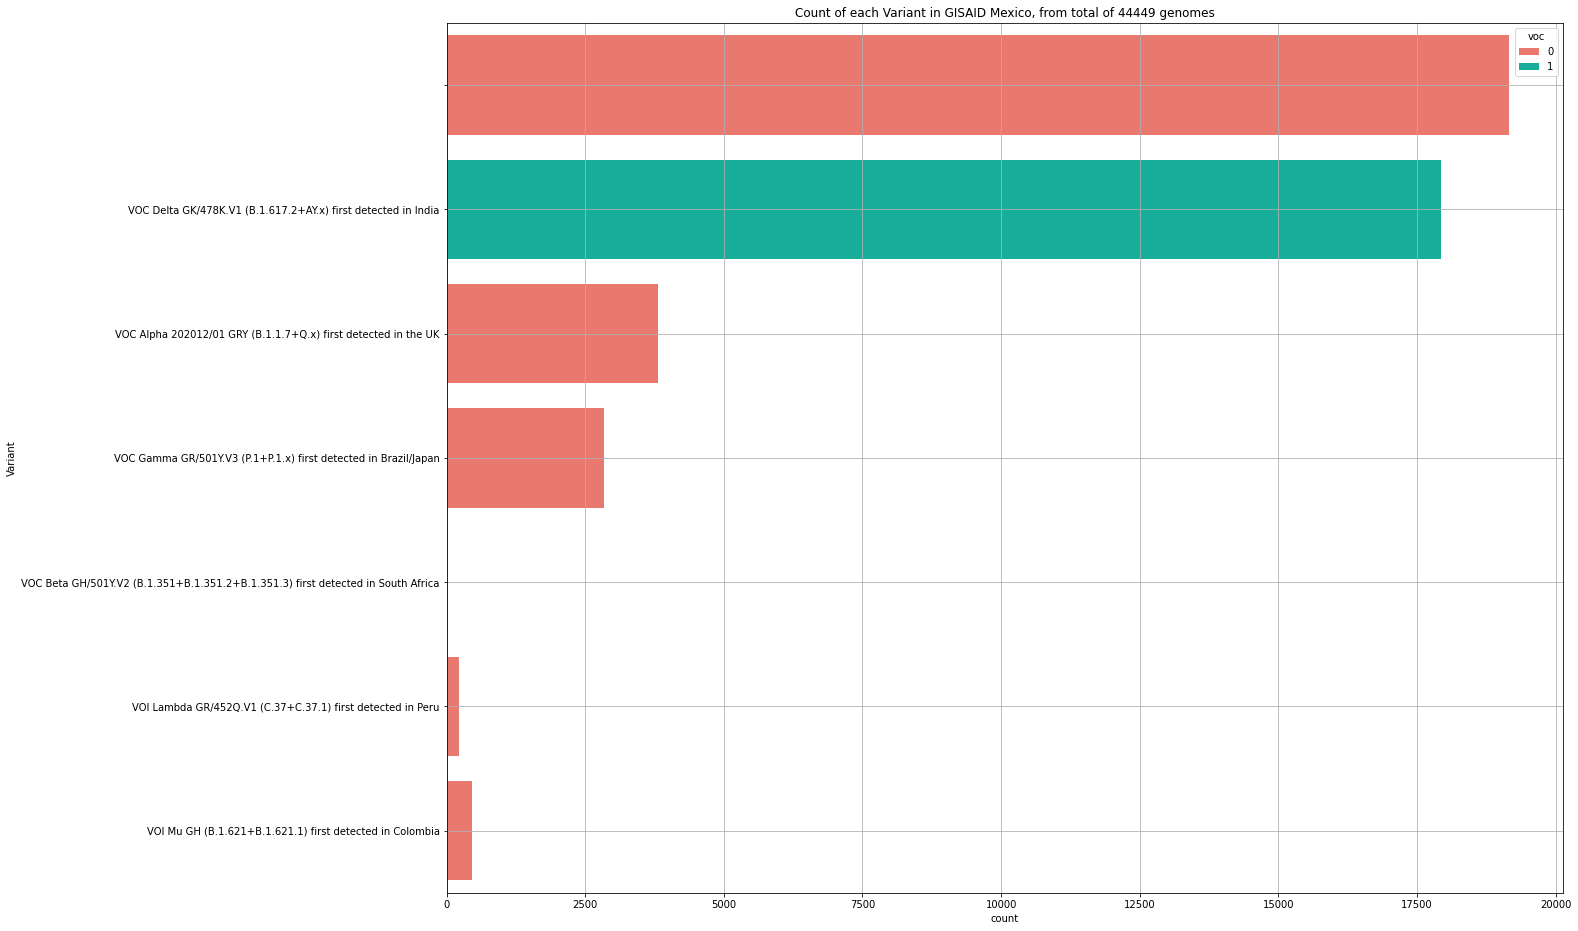

In [6]:
genomes = gisaid[gisaid[gisaid_location_col].str.contains(region)]
del gisaid # free up space
genomes['Date_collection_dt'] = pd.to_datetime(genomes[gisaid_date_col],format='%Y-%m-%d')
genomes.fillna(value='',inplace=True)
genomes['cases'] = 1
# genomes['voc'] = genomes.apply(lambda x: (1 if x[gisaid_lineage_col]==variant else 0),axis=1)
# genomes['voc'] = genomes.apply(lambda x: (0 if x[gisaid_lineage_col]==variant else 1),axis=1)
genomes['voc'] = genomes.apply(lambda x: (1 if variant in x[gisaid_lineage_col] else 0),axis=1)
genomes['other'] = genomes.apply(lambda x: (0 if variant in x[gisaid_lineage_col] else 1),axis=1)
genomes.sort_values(by='Date_collection_dt',inplace=True)

colors = gh_palette[3:5]

fig,ax = plt.subplots(figsize=(20,16))
sns.countplot(y=gisaid_lineage_col, data=genomes,hue='voc',orient='h',ax=ax,dodge=False)
# sns.catplot(y=gisaid_lineage_col, data=genomes,hue='voc',orient='h',ax=ax)
ax.grid(b=True)
ax.set_title(f"Count of each Variant in GISAID {region}, from total of {len(genomes)} genomes")

# genomes[genomes['voc']==1][gisaid_lineage_col].value_counts().sort_values().plot(kind = 'barh',label='VoC lineages',ax=ax)

In [ ]:
# print(f"{len(genomes)} genomes from {region}")

#### Extract actual age from GISAID data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count')

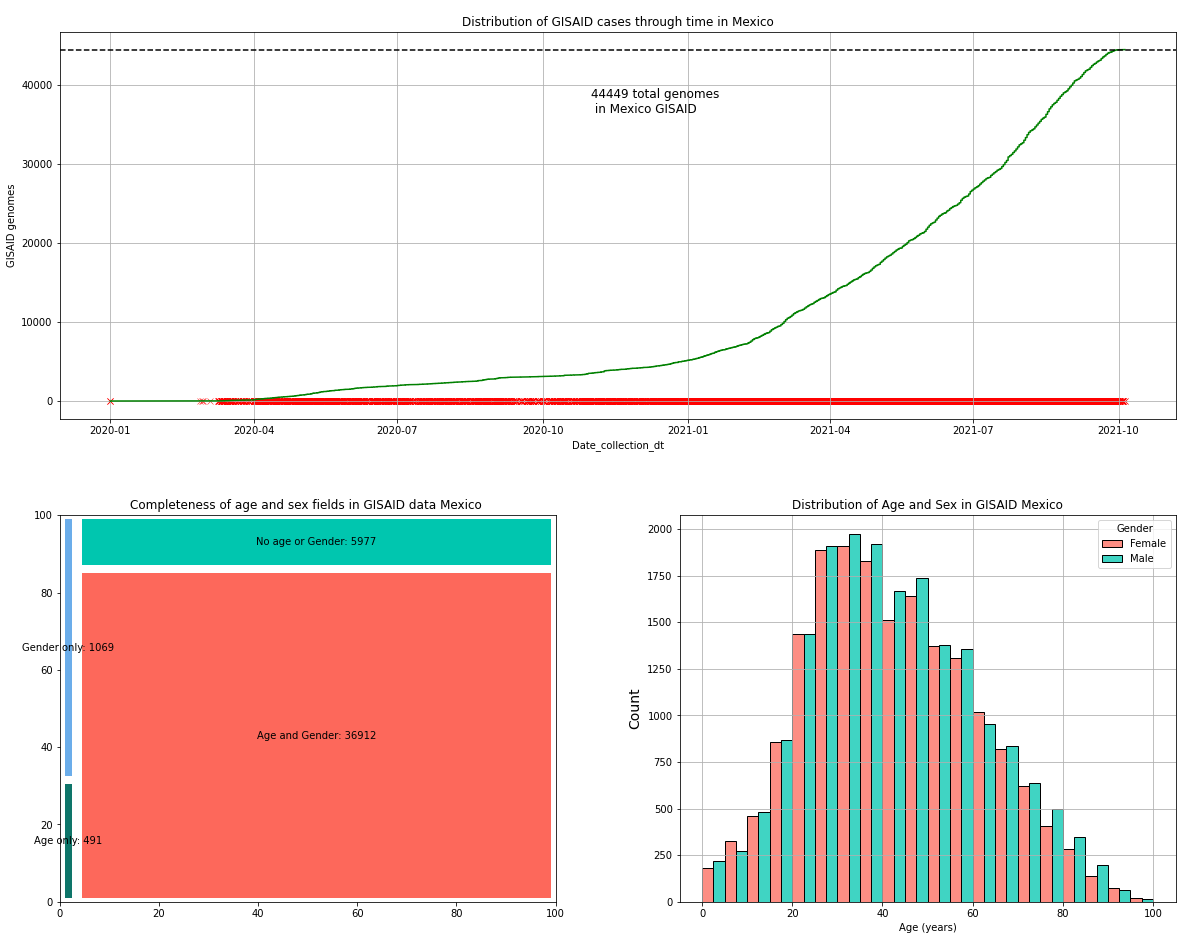

In [7]:
def get_gisaid_age(row):
    age = row['Patient age']
    try: 
        return int(age)
    except:
        return ''
    
genomes['actual_age'] = genomes.apply(get_gisaid_age,axis=1)


fig = plt.figure(figsize=(20, 16))
plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
figure_rows = 2
figure_cols = 2

# fraction_genomes_with_age = 100*len(genomes.loc[genomes['actual_age']!='','actual_age'])/len(genomes)
genomes_with_age = genomes.loc[genomes['actual_age']!='']
genomes_with_gender = genomes[genomes['Gender'].isin(['Male','Female'])].reset_index(drop=True)
genomes_with_age_and_gender = genomes_with_age[genomes_with_age['Gender'].isin(['Male','Female'])].reset_index(drop=True)


## A
sub1 = fig.add_subplot(figure_rows,figure_cols,(1,2)) # row 1 first two columns
sns.scatterplot(genomes['Date_collection_dt'],genomes['cases'],y_jitter=True,marker='x',color='red',ax=sub1)
sub1.grid(b=True)
sub1.set_title(f'Distribution of GISAID cases through time in {region}')

genomes = genomes.sort_values(by='Date_collection_dt')
genomes['cases_sum'] = genomes['cases'].cumsum()
sub1.plot(genomes['Date_collection_dt'],genomes['cases_sum'],color='g')
sub1.set_ylabel('GISAID genomes')
sub1.axhline(genomes['cases_sum'].iloc[-1],color="black", linestyle="--")
sub1.annotate(f"{genomes['cases_sum'].iloc[-1]} total genomes\n in {region} GISAID",(0.5,0.88),xycoords='figure fraction',fontsize=12)


sub2 = fig.add_subplot(figure_rows,figure_cols,3)

gisaid_completeness = {}
gisaid_completeness['Age only'] = genomes.loc[(genomes['actual_age']!='') & (~genomes['Gender'].isin(['Male','Female']))].shape[0]
gisaid_completeness['Gender only'] = genomes.loc[(genomes['actual_age']=='') & (genomes['Gender'].isin(['Male','Female']))].shape[0]
gisaid_completeness['Age and Gender'] = genomes.loc[(genomes['actual_age']!='') & (genomes['Gender'].isin(['Male','Female']))].shape[0]
gisaid_completeness['No age or Gender'] = genomes.loc[(genomes['actual_age']=='') & (~genomes['Gender'].isin(['Male','Female']))].shape[0]
labels = [f"{u}: {gisaid_completeness[u]}" for u in gisaid_completeness.keys()]
colors = ['#007AEC','#0E7569','#6BADEA','#FD685B','#00C6AF','#FD9986']

## Choose venn or tree diagram
# venn2(subsets = (gisaid_completeness['Age only'], gisaid_completeness['Gender only'], gisaid_completeness['Age and Gender']), set_labels = ('Genomes with Age', 'Genomes with Gender'),ax=sub2)
squarify.plot(gisaid_completeness.values(),label=labels,color = colors[1:5] ,ax=sub2,pad=2)
sub2.set_title(f'Completeness of age and sex fields in GISAID data {region} ')

sub3 = fig.add_subplot(figure_rows,figure_cols,4)
# sns.histplot(data=genomes_mf,x='actual_age',hue='Gender',multiple='dodge',stat='probability',fill=True,color='#00C6AF',kde=False,ax=sub6,binwidth=5,binrange=(0,100))
# sns.histplot(data=genomes_mf,x='actual_age',hue='Gender',multiple='dodge',stat='count',fill=True,kde=False,binwidth=5,binrange=(0,100),ax=sub3)
sns.histplot(data=genomes_with_age_and_gender,x='actual_age',hue='Gender',multiple='dodge',stat='count',fill=True,kde=False,binwidth=5,binrange=(0,100),ax=sub3)
sub3.set_title(f'Distribution of Age and Sex in GISAID {region}')
sub3.grid(b=True)
sub3.set_xlabel('Age (years)')
sub3.set_ylabel('Count',rotation=90,fontsize=14,labelpad=5)

### VoC prevalence

- Aggregate GISAID cases by day and week

In [10]:
genomes_days = genomes.copy(deep=True)
genomes_days = genomes_days.groupby(pd.Grouper(key='Date_collection_dt', freq='D')).sum().reset_index().drop(columns=['Sequence length'])
genomes_days['epiweek'] = genomes_days['Date_collection_dt'].dt.isocalendar().week
# Make sure epiweek doesn't restart in new year -> add 53 to first new week in new year (starts on 2021-01-04)
genomes_days['epiweek'] = genomes_days.apply(lambda x: (x['epiweek'] + 53 if x['Date_collection_dt'] > pd.to_datetime('2021-01-03') else x['epiweek']),axis=1)
genomes_days['region'] = region
genomes_days['voc_cumsum'] = genomes_days['voc'].cumsum()
genomes_days['other_cumsum'] = genomes_days['other'].cumsum()
genomes_days['time_unit'] = np.arange(1,len(genomes_days)+1)
genomes_days = genomes_days.rename(columns={'Date_collection_dt':'date'}).loc[:,['date','region','voc','other','voc_cumsum','other_cumsum','cases','epiweek','time_unit']]

In [11]:
genomes_week = genomes.copy(deep=True)
genomes_week = genomes_week.groupby(pd.Grouper(key='Date_collection_dt', freq='W')).sum().reset_index().drop(columns=['Sequence length'])
genomes_week['epiweek'] = genomes_week['Date_collection_dt'].dt.isocalendar().week
# Make sure epiweek doesn't restart in new year -> add 53 to first new week in new year (starts on 2021-01-04)
genomes_week['epiweek'] = genomes_week.apply(lambda x: (x['epiweek'] + 53 if x['Date_collection_dt'] > pd.to_datetime('2021-01-03') else x['epiweek']),axis=1)
genomes_week['region'] = region
genomes_week['voc_cumsum'] = genomes_week['voc'].cumsum()
genomes_week['other_cumsum'] = genomes_week['other'].cumsum()
genomes_week['time_unit'] = np.arange(1,len(genomes_week)+1)
genomes_week = genomes_week.rename(columns={'Date_collection_dt':'date'}).loc[:,['date','region','voc','other','voc_cumsum','other_cumsum','cases','epiweek','time_unit']]

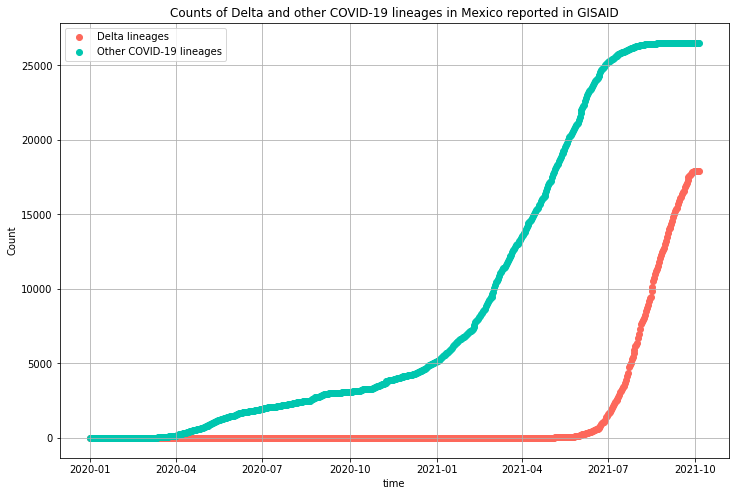

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(genomes_days['date'],genomes_days['voc_cumsum'],label=f"{variant} lineages")
plt.scatter(genomes_days['date'],genomes_days['other_cumsum'],label='Other COVID-19 lineages')
plt.grid(b=True)
plt.title(f'Counts of {variant} and other COVID-19 lineages in {region} reported in GISAID')
plt.ylabel('Count')
plt.xlabel('time')
plt.legend()

### Try naive GLM to fit data

- Fit a GLM with a logit link function and binomial distribution

https://www.statsmodels.org/stable/glm.html

### Build model on either daily or weekly aggregated genome counts

In [13]:
model_weekly_counts = True

In [14]:
if model_weekly_counts:
    data = genomes_week
    n_time_units = 2*data['time_unit'].iloc[-1]
    predictions_df = pd.DataFrame([])
    predictions_df['time_unit'] = np.arange(1,n_time_units+1)
    predictions_df['date'] = pd.date_range(start=data['date'][0],end=data['date'][0]+timedelta(weeks=int(n_time_units)-1),freq='W')
else:
    data = genomes_days
    n_time_units = 2*data['time_unit'].iloc[-1]
    predictions_df = pd.DataFrame([])
    predictions_df['time_unit'] = np.arange(1,n_time_units+1)
    predictions_df['date'] = pd.date_range(start=data['date'][0],end=data['date'][0]+timedelta(days=int(n_time_units)-1),freq='D')

In [15]:
# data = data[(data['voc']!=0)|(data['other']!=0)]
data_exog = sm.add_constant(data['time_unit'])
# data_exog = data['day']
data_endog = data[['voc_cumsum','other_cumsum']]
binom_model = sm.GLM(data_endog, data_exog, family=sm.families.Binomial())
binom_results = binom_model.fit()
binom_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Generalized Linear Model Regression Results                        
==========================================================================================
Dep. Variable:     ['voc_cumsum', 'other_cumsum']   No. Observations:                   93
Model:                                        GLM   Df Residuals:                       91
Model Family:                            Binomial   Df Model:                            1
Link Function:                              logit   Scale:                          1.0000
Method:                                      IRLS   Log-Likelihood:                -7308.0
Date:                            Wed, 20 Oct 2021   Deviance:                       14305.
Time:                                    22:13:33   Pearson chi2:                 1.27e+04
No. Iterations:                                 8                                         
Covariance Type:                        nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.9707      0.050   -337.116      0.000     -17.069     -16.872
time_unit      0.1834      0.001    317.656      0.000       0.182       0.184
==============================================================================
"""

In [16]:
# predictions['fitted_value'] = binom_results.predict(sm.add_constant(predictions['time_unit']))
preds_object = binom_results.get_prediction(sm.add_constant(predictions_df['time_unit']))
model_fit_preds = preds_object.summary_frame(alpha=0.05)
model_fit_preds['time_unit'] = predictions_df['time_unit']

predictions_df = predictions_df.merge(model_fit_preds,on='time_unit')

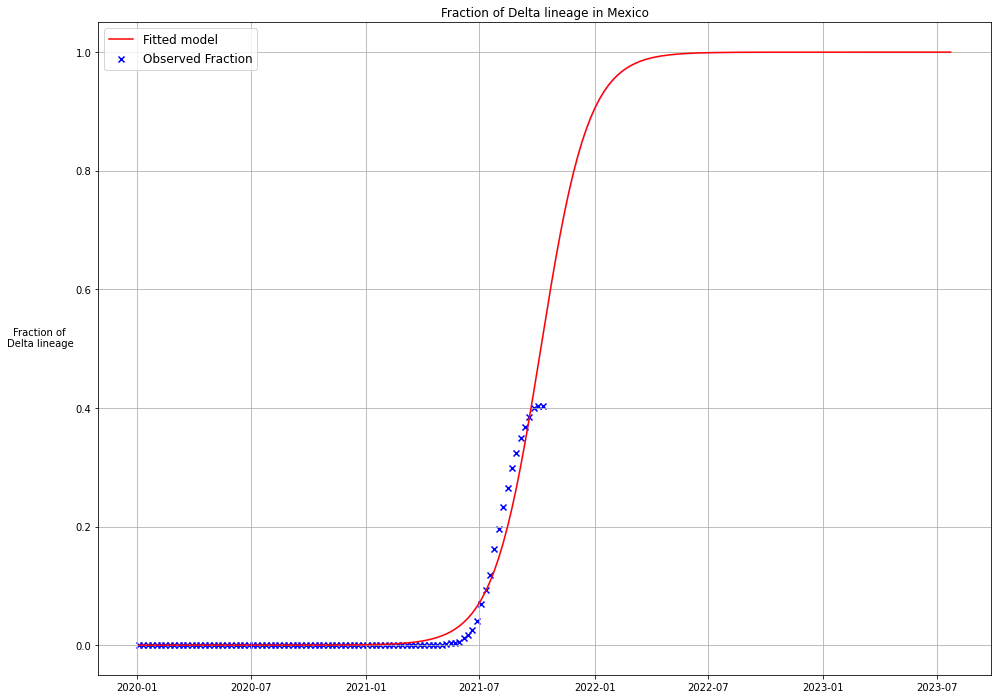

In [17]:
fig,ax = plt.subplots(figsize=(16,12))
ax.scatter(data['date'],data['voc_cumsum']/(data['voc_cumsum']+data['other_cumsum']),marker='x',label='Observed Fraction',color='b')
ax.plot(predictions_df['date'],predictions_df['mean'],'r',label='Fitted model')
ax.fill_between(predictions_df['date'], predictions_df['mean_ci_lower'], predictions_df['mean_ci_upper'] , color='b', alpha=.1)
ax.set_ylabel(f'Fraction of \n{variant} lineage',rotation=0,labelpad=35)
ax.set_title(f'Fraction of {variant} lineage in {region}')

plt.legend(fontsize=12)
plt.grid(b=True)

# Global.health Linelist data 

In [18]:
linelist_file = '/content/drive/MyDrive/global_health/mexico.csv'
# linelist_file = '/Users/felson/Documents/DPhil/global_health/delay_distributions/mexico.csv'
# linelist_file = '/Users/felson/Documents/DPhil/global_health/delay_distributions/argentina.csv'
# linelist_file = '/Users/felson/Documents/DPhil/global_health/delay_distributions/peru.csv'
linelist = pd.read_csv(linelist_file,sep=',')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Make necessary columns

- Extract relevant events, ie date_confirmed, which is stored as a string representation of dictionary (of variable number of keys)

- Case Age (in years)

In [19]:
linelist['confirmed_datetime'] = pd.to_datetime([json.loads(u)['confirmed']['date'] for u in linelist['events']],format='%Y-%m-%d')
linelist = linelist.sort_values(by='confirmed_datetime').reset_index(drop=True)
linelist = linelist[pd.notnull(linelist['confirmed_datetime'])]
linelist['cases'] = 1
linelist['case_sum'] = linelist['cases'].cumsum()



#### Aside: Check coverage of other events such as onset symptoms

In [20]:
onset_symptom_dates = []
count = 0
for raw_event in linelist['events']:
    event_dict = json.loads(raw_event)
    try:
        onset_symptom_dates.append(pd.to_datetime(event_dict['onsetSymptoms']['date'],format='%Y-%m-%d'))
        count+=1
    except:
        onset_symptom_dates.append('')
        
        
onset_symptom_coverage = count / len(linelist['events'])
print(f'Onset symptoms date coverage = {100*onset_symptom_coverage:2f}')

Onset symptoms date coverage = 0.056551


### Parsing Age

- How many cases provide a non-exact age range? We (probably) need to remove these cases

- For remaining cases, set 'age_years' to demographics.ageRange.start



In [21]:
linelist['age_range'] = linelist['demographics.ageRange.end'] - linelist['demographics.ageRange.start']
print(f'Cases with age range rather than exact age: {len(linelist.loc[linelist["age_range"]>0,:])}')


Cases with age range rather than exact age: 0


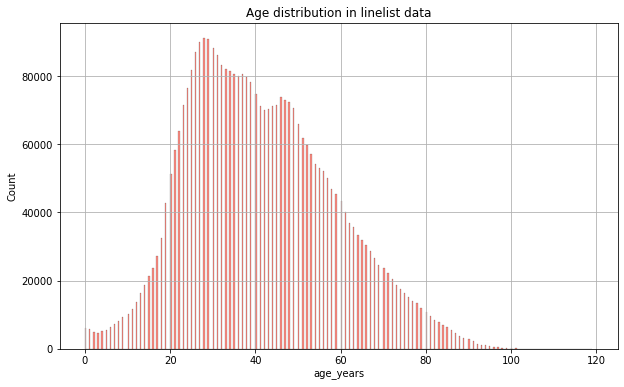

In [22]:
linelist['age_years'] = linelist['demographics.ageRange.start']

plt.figure(figsize=(10,6))
sns.histplot(linelist['age_years'] )
plt.title('Age distribution in linelist data')
plt.grid(b=True)

#### Parsing Gender

In [23]:
linelist_sex_column = 'demographics.gender'
gender_coverage = linelist[pd.notnull(linelist[linelist_sex_column])].shape[0]/linelist.shape[0]
print(f"Linelist gender coverage = {gender_coverage*100:.3f}%")

Linelist gender coverage = 99.999%


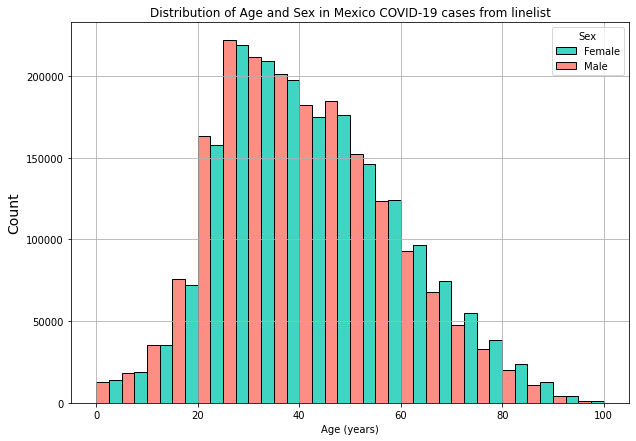

In [24]:
# linelist[pd.notnull(linelist['demographics.gender'])]
linelist_sex_column = 'demographics.gender'
linelist_mf = linelist[pd.notnull(linelist[linelist_sex_column])]
linelist_m = linelist[linelist[linelist_sex_column]=='Male']
linelist_f = linelist[linelist[linelist_sex_column]=='Female']

fig,ax = plt.subplots(figsize=(10,7))
sns.histplot(data=linelist_mf,x='age_years',hue=linelist_sex_column,multiple='dodge',stat='count',fill=True,kde=False,binwidth=5,binrange=(0,100),ax=ax)
ax.set_title(f'Distribution of Age and Sex in {region} COVID-19 cases from linelist')
ax.grid(b=True)
ax.set_xlabel('Age (years)')
ax.set_ylabel('Count',rotation=90,fontsize=14,labelpad=5)
ax.legend(['Female','Male'],title='Sex')

### Make weekly aggregated datasets for linelist

In [25]:
linelist_weekly = linelist.groupby(pd.Grouper(key='confirmed_datetime', freq='W')).sum().reset_index()

#### Sanity check: plot linelist weekly cases through time

Text(0, 0.5, 'Case count')

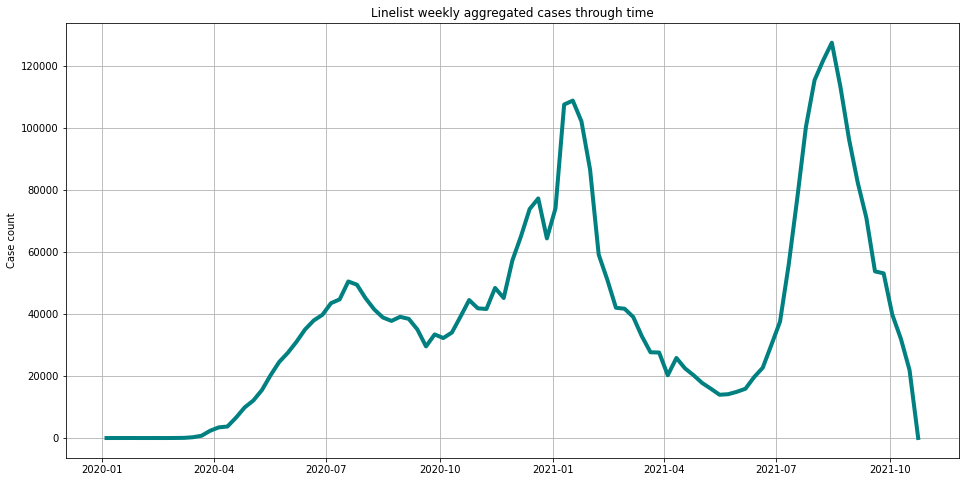

In [26]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(linelist_weekly['confirmed_datetime'],linelist_weekly['cases'],linewidth=4,color='teal')
ax.grid(b=True)
ax.set_title('Linelist weekly aggregated cases through time')
ax.set_ylabel('Case count')

## Relative Risk calculations

Calculations follow the Goldstein _et al_ paper: https://www.medrxiv.org/content/10.1101/2020.04.08.20058719v1.full.pdf

Relative risk is defined as:

\begin{align}
RR(g) = \frac{L(g)}{\sum_{h=1}^{8}L(h)} / \frac{E(g)}{\sum_{h=1}^{8}E(h)}
\end{align}

where L and E are two supposedly distinct data groups with distinct sampling distributions, and L(g) and E(g) represents the subset of these datasets within each age group g. Relative risk is therefore given by (P(event) in group L) /  (P(event) in group E), which here is calculated from counts in each group.

95% Confidence intervals for relative risk are calculated as:

\begin{align}
CI_{95} = \exp({\ln({RR(g)) \pm 1.96\times SE }})
\end{align}

where standard error SE is given by:

\begin{align}
SE = \sqrt{\frac{1}{L(g))} + \frac{1}{E(g))} - (\frac{1}{\sum_{h=1}^{8}L(h))} + \frac{1}{\sum_{h=1}^{8}E(h)} )}
\end{align}

As in Goldstein _et al_, this makes the assumption that the numbers of reported cases are sufficiently high such that the logarithm, ln(𝑅𝑅𝑔), of the relative risk in each age group is approximately normally distributed.


# Generate Figures 

Figure 1: a) Number of cases per week, optional a2 = number of weekly deaths/hospitalisations etc if available) b) Number of genomes per week (split P.1 and non P.1). c) Histogram (age/sex distribution).

Figure 2: a) Modelled frequency of P.1 (using either GLM or stan model depending on quality of data), b) RR genomes vs. cases SRAG, c) RR genomes P.1 vs. genomes non-P.1, d) RR genomes P.1 vs. cases when P.1 hit >80% d) RR genomes vs. cases SRAG.

In [27]:
first_gisaid_voc_case = genomes[genomes['voc']==1].sort_values(by='Date_collection_dt').reset_index(drop=True)['Date_collection_dt'][0]

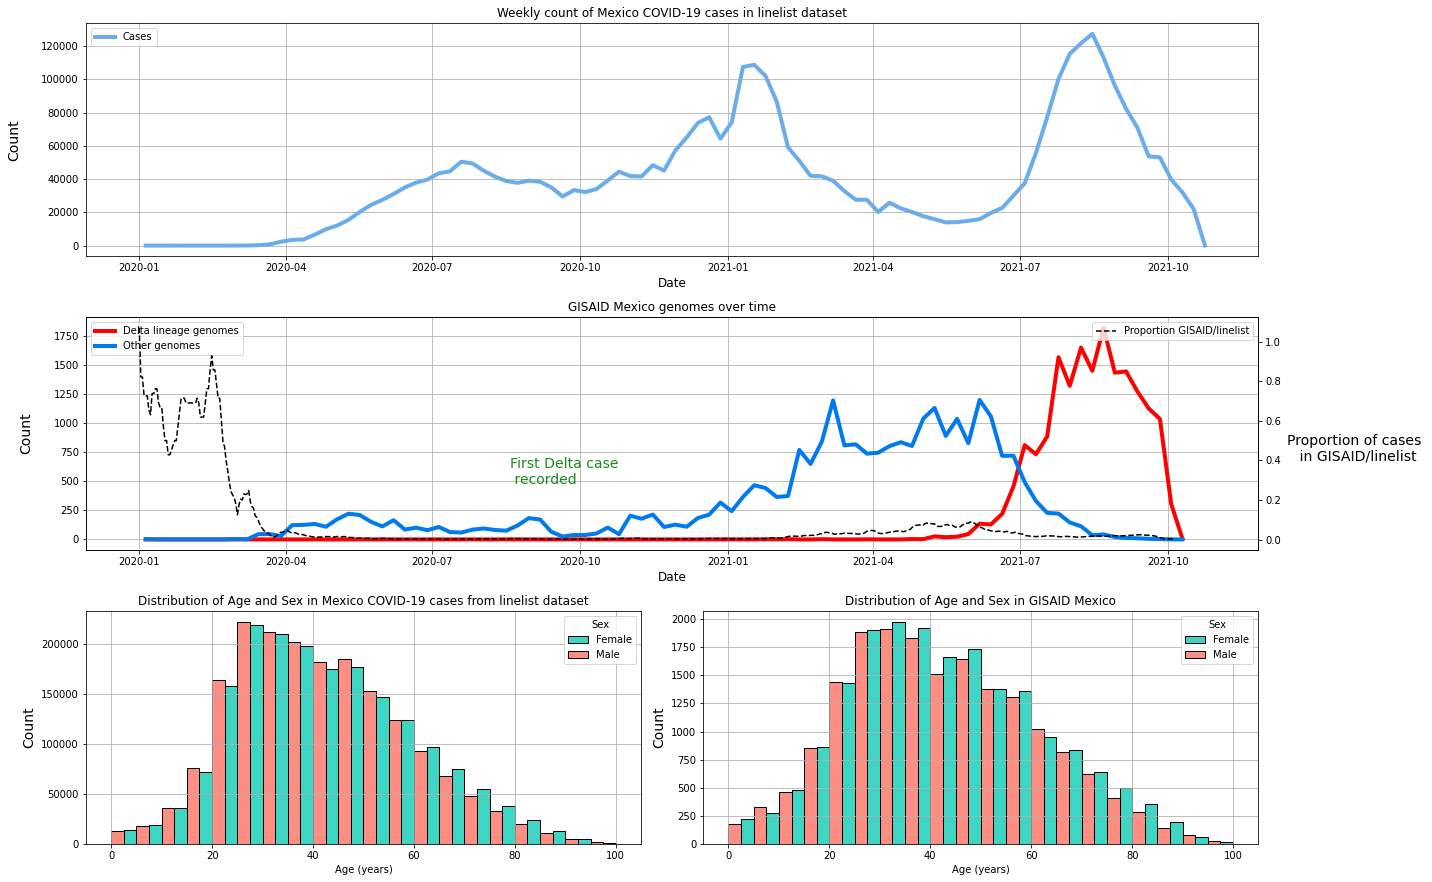

In [28]:
def rolling_average(x,N):
    x = np.array(x)
    av = np.convolve(x, np.ones(N)/N, mode='valid')
    return np.append(av, x[-(N-1):])


apply_rolling_average = True
fig = plt.figure(figsize=(20, 16))
plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
figure_rows = 4
figure_cols = 2

## A
sub1 = fig.add_subplot(figure_rows,figure_cols,(1,2)) # two rows, two columns, third cell
sub1.plot(linelist_weekly['confirmed_datetime'],linelist_weekly['cases'],label='Cases',linewidth=4,color='#6BADEA')
# sub1.plot(linelist_weekly['confirmed_datetime'],linelist_weekly['hospital_count'],label='Hospitalised Cases')
# sub1.plot(linelist_weekly['confirmed_datetime'],linelist_weekly['death_count'],label='Deaths attributed to COVID-19',color='#FD9986',linewidth=4)
# sub1.plot(linelist_weekly['confirmed_datetime'],linelist_weekly['icu_count'],label='Cases admitted to ICU',linewidth=4,color='#00C6AF')


sub1.grid(b=True)
sub1.set_title(f'Weekly count of {region} COVID-19 cases in linelist dataset')
sub1.set_ylabel('Count',rotation=90,fontsize=14,labelpad=20)
sub1.set_xlabel('Date',fontsize=12)
sub1.legend(loc = 'upper left')



sub2 = fig.add_subplot(figure_rows,figure_cols,(3,4),sharex=sub1) # three rows, two columns, first cell
# sub2.plot(genomes_days['date'],rolling_average(genomes_days['voc'],7),label='P lineage genomes',color='red',linestyle='-',linewidth=4)
# sub2.plot(genomes_days['date'],rolling_average(genomes_days['other'],7),label='Other genomes',color='#007AEC',linestyle='-',linewidth=4)
sub2.plot(genomes_week['date'],genomes_week['voc'],label=f'{variant} lineage genomes',color='red',linestyle='-',linewidth=4)
sub2.plot(genomes_week['date'],genomes_week['other'],label='Other genomes',color='#007AEC',linestyle='-',linewidth=4)
sub2.set_xlabel('Date',fontsize=12)
## Label first P.1 case in GISAID
sub2.vlines(first_gisaid_voc_case,0,7,color='green',linestyle='--')
sub2.text(first_gisaid_voc_case-timedelta(days=35),genomes_week['cases'].mean(),f'First {variant} case \n recorded',color='green',alpha=0.9,fontsize=14)
sub2.grid(b=True)
sub2.set_ylabel('Count',rotation=90,fontsize=14,labelpad=20)
sub2.set_title(f'GISAID {region} genomes over time')
sub2.legend(loc = 'upper left')

## Add secondary axis with proportion of SRAG in GISAID
sub25 = sub2.twinx()
linelist_daily = linelist.groupby(pd.Grouper(key='confirmed_datetime', freq='D')).sum()['cases'].reset_index()
linelist_in_gisaid = linelist_daily.loc[linelist_daily['confirmed_datetime'].isin(genomes_days['date'])]
proportion_gisaid_in_linelist = rolling_average((genomes_days['cases']+1)/(linelist_in_gisaid['cases']+1),7)
# proportion_gisaid_in_linelist = (genomes_days['cases']+1)/(linelist_in_gisaid['cases']+1)
# sub15.plot(genomes_week['date'],proportion_gisaid_in_srag,color='k',linestyle='--',label='Proportion GISAID/SRAG')
sub25.plot(genomes_days['date'],proportion_gisaid_in_linelist,color='k',linestyle='--',label='Proportion GISAID/linelist')
# sub1.scatter(genomes_week['date'],genomes_week['other'],color='#6BADEA',marker='x')
# sub1.fill_between(genomes_week['date'],genomes_week['B117'],color='#FD9986',alpha=0.2,label='Cumulative P.1 genomes')
# sub1.fill_between(genomes_week['date'],genomes_week['Other'],color='#6BADEA',alpha=0.2,label='Cumulative other genomes')
sub25.legend()
sub25.set_ylabel('Proportion of cases \n in GISAID/linelist',rotation=0,labelpad=75,fontsize=14)

# Histogram of Age and Sex in linelist
linelist_sex_column = 'demographics.gender'
linelist_mf = linelist[pd.notnull(linelist[linelist_sex_column])]
linelist_m = linelist[linelist[linelist_sex_column]=='Male']
linelist_f = linelist[linelist[linelist_sex_column]=='Female']

sub3 = fig.add_subplot(figure_rows,figure_cols,5)
sns.histplot(data=linelist_mf,x='age_years',hue=linelist_sex_column,multiple='dodge',stat='count',fill=True,kde=False,ax=sub3,binwidth=5,binrange=(0,100))
sub3.set_title(f'Distribution of Age and Sex in {region} COVID-19 cases from linelist dataset')
sub3.grid(b=True)
sub3.set_xlabel('Age (years)')
sub3.set_ylabel('Count',rotation=90,fontsize=14,labelpad=5)
sub3.legend(['Female','Male'],title='Sex')


# # Histogram of Age and Sex in GISAID
sub4 = fig.add_subplot(figure_rows,figure_cols,6)
# sns.histplot(data=genomes_mf,x='actual_age',hue='Gender',multiple='dodge',stat='probability',fill=True,color='#00C6AF',kde=False,ax=sub6,binwidth=5,binrange=(0,100))
# sns.histplot(data=genomes_mf,x='actual_age',hue='Gender',multiple='dodge',stat='count',fill=True,kde=False,binwidth=5,binrange=(0,100),ax=sub3)
sns.histplot(data=genomes_with_age_and_gender,x='actual_age',hue='Gender',multiple='dodge',stat='count',fill=True,kde=False,binwidth=5,binrange=(0,100),ax=sub4)
sub4.set_title(f'Distribution of Age and Sex in GISAID {region}')
sub4.grid(b=True)
sub4.set_xlabel('Age (years)')
sub4.set_ylabel('Count',rotation=90,fontsize=14,labelpad=5)

# sub45 = sub4.twinx()
# sns.histplot(data=genomes_mf,x='actual_age',hue='Gender',multiple='dodge',stat='count',fill=True,color='#00C6AF',kde=False,ax=sub65,binwidth=5,binrange=(0,100))
# sns.histplot(data=genomes_mf,x='actual_age',hue='Gender',multiple='dodge',stat='count',fill=True,kde=False,ax=sub45,binwidth=5,binrange=(0,100))
# sub45.set_ylabel('Count',rotation=90,fontsize=14,labelpad=5)
sub4.legend(['Female','Male'],title='Sex')

plt.tight_layout()
# plt.savefig('/place/to/save/fig.png')


# Figure 2

## Set key dates for VoC emergence

- First case in linelist and GISAID

- Date of first VOC __taken from model__ or from GISAID?

We define two periods: __early__ and __late__. 

- Early period = from first case in _linelist_ until date of first case with the VoC.

- Late period = from date VoC fraction was greater than threshold value, until last case in _linelist_.




#### Set VOC threshold frequency percentage (at which to start the late period)

In [33]:
voc_frequency = 20 # need to use a low frequency currently, because last linelist date is when VoC frequency remains low

In [34]:
date_of_first_case_in_linelist = linelist['confirmed_datetime'][0] 
first_gisaid_case = genomes.sort_values(by='Date_collection_dt')['Date_collection_dt'].reset_index(drop=True)[0]
first_gisaid_voc_case = genomes[genomes['voc']==1].sort_values(by='Date_collection_dt').reset_index(drop=True)['Date_collection_dt'][0]
_,first_voc_case_from_model = get_date_for_fraction(0.01,predictions_df) # TODO: this exact fraction should be calculated - what fraction is the first case of total, and what should the denominator be?

# Select first voc case as one of the above options
first_voc_case = first_gisaid_voc_case

early_start = linelist['confirmed_datetime'][0]
early_end = first_voc_case 

_,late_start = get_date_for_fraction(voc_frequency/100,predictions_df)
# late_end = all_freq_values['date'].iloc[-1]
late_end = linelist.sort_values(by='confirmed_datetime')['confirmed_datetime'].iloc[-1]

linelist_early = linelist[(linelist['confirmed_datetime'] > early_start) & (linelist['confirmed_datetime'] < early_end)]
linelist_late = linelist[(linelist['confirmed_datetime'] > late_start) & (linelist['confirmed_datetime'] < late_end)]

print(f"early period is from {early_start} to {early_end}")
print(f"late period is from {late_start} to {late_end}")

early period is from 2020-01-01 00:00:00 to 2020-09-22 00:00:00
late period is from 2021-08-08 00:00:00 to 2021-10-18 00:00:00


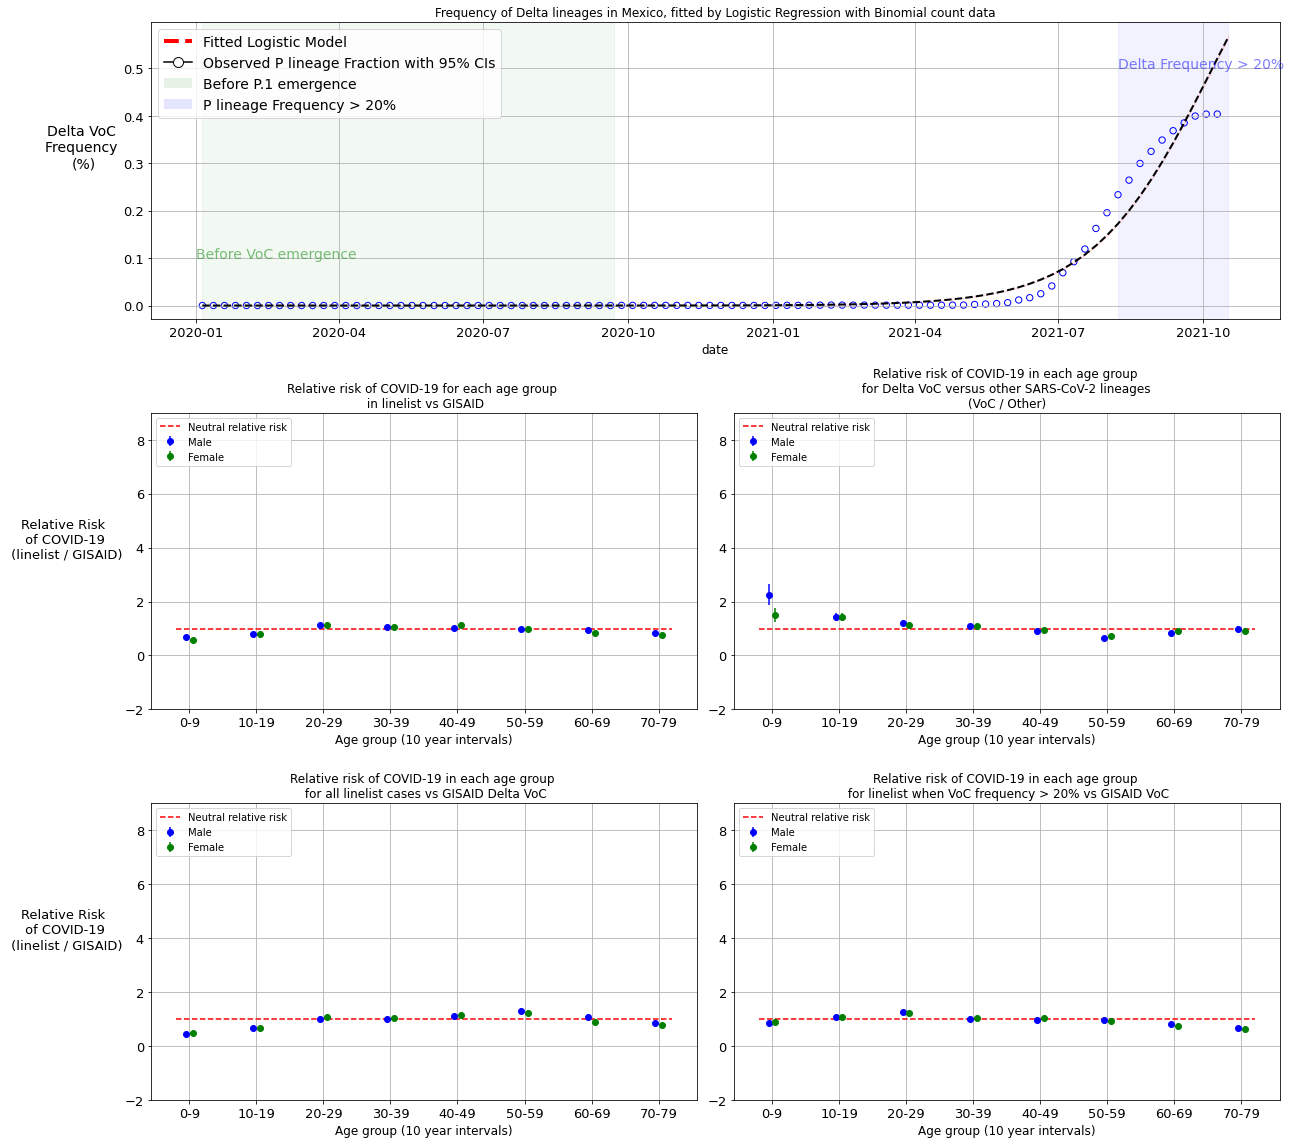

In [35]:
fig = plt.figure(figsize=(18, 16))
plt.subplots_adjust(wspace= 68, hspace= 50.25)

# a) Modelled frequency of VoC (using either GLM or stan model depending on quality of data)
sub1 = fig.add_subplot(3,2,(1,2))
sub1.scatter(data['date'],data['voc_cumsum']/(data['voc_cumsum']+data['other_cumsum']),marker='o',
             facecolors='none',
             edgecolors='blue',
             label=f'Observed Fraction {variant} lineages',
            s=40)
predictions_subset = predictions_df.loc[predictions_df['date']<datetime.today(),:]
sub1.plot(predictions_subset['date'],predictions_subset['mean'],'k--',label='Fitted logistic model',lw=2)
sub1.fill_between(predictions_subset['date'], predictions_subset['mean_ci_lower'], predictions_subset['mean_ci_upper'] , color='red', alpha=.1)

sub1.axvspan(predictions_df['date'][0], first_voc_case, alpha=0.05, color='green',label=f'Before {variant} emergence')
# sub1.axvspan(late_start, predictions_df['date'][80], alpha=0.05, color='blue',label=f'P lineage frequency > {voc_frequency}%')
sub1.axvspan(late_start, predictions_subset['date'].iloc[-1], alpha=0.05, color='blue',label=f'{variant} lineage frequency > {voc_frequency}%')
sub1.text(early_start,0.1,'Before VoC emergence',color='green',alpha=0.5,fontsize=14)
sub1.text(late_start,0.5,f'{variant} Frequency > {voc_frequency}%',color='blue',alpha=0.5,fontsize=14)
sub1.legend()
sub1.grid(b=True)
sub1.set_ylabel(f'{variant} VoC \nFrequency \n(%)',rotation=0,labelpad=40,fontsize=14)
sub1.set_xlabel('date',fontsize=12)
sub1.tick_params(labelsize=13)
legend_elements = [Line2D([0], [0], color='r',linestyle='dashed',lw=4, label='Fitted Logistic Model'),
                   Line2D([0], [0], marker='o', color='k', label='Observed P lineage Fraction with 95% CIs',
                          markerfacecolor='white', markersize=10),
                   Patch(facecolor='green',alpha=0.1,
                         label='Before P.1 emergence'),
                    Patch(facecolor='blue',alpha=0.1,
                         label=f'P lineage Frequency > {voc_frequency}%')]



sub1.legend(handles=legend_elements, loc='upper left',fontsize=14)
sub1.set_title(f'Frequency of {variant} lineages in {region}, fitted by Logistic Regression with Binomial count data')
# plt.plot(days_predict,predicted_vals,'r-' )
# plt.plot(days_predict,binom_results.predict(exog_predict),'g:',label='Extrapolated')
# plt.xticks(pd.date_range(start=data['date'][0],end=data['date'][0]+timedelta(days=600)))
plt.tight_layout()



# b) RR genomes vs. linelist 
linelist_age_col = 'age_years'
gisaid_age_col = 'actual_age'


## set interval
start,end,interval = 0,80,10
# start,end,interval = 0,90,15
ci=True

xticklabels = []
for x in range(start,end,interval):
    xticklabels.append(f"{x}-{x+interval-1}")
    
sub2 = fig.add_subplot(3,2,3)
for gender in ['Male','Female']:
    gisaid_gender = genomes_with_age_and_gender[genomes_with_age_and_gender['Gender']==gender]
    linelist_gender = linelist[linelist[linelist_sex_column]==gender]
#     age_relative_risk,age_standard_errors,upper_ci,lower_ci,lowrisk_count_dict,highrisk_count_dict,lowrisk_fraction_dict,highrisk_fraction_dict,lowrisk_total_dict,highrisk_total_dict = get_RR_SE_boolean_col('empty',yes,no,gisaid_gender,linelist_gender,gisaid_age_col,linelist_age_col,start,end,interval,total_counts=True)
    relative_risk_dict = get_RR_SE_counts(gisaid_gender,linelist_gender,gisaid_age_col,linelist_age_col,start,end,interval)
    relative_risk_df = pd.DataFrame.from_dict(relative_risk_dict)

    if gender=='Male':
        sub2.errorbar(relative_risk_df['start_age']-0.5,
                relative_risk_df['relative_risk'],
                yerr=(relative_risk_df['upper_CI']-relative_risk_df['lower_CI'])/2, 
                fmt='o',
                  label='Male',
               color='blue')
    else:
        sub2.errorbar(relative_risk_df['start_age']+0.5,
            relative_risk_df['relative_risk'],
            yerr=(relative_risk_df['upper_CI']-relative_risk_df['lower_CI'])/2, 
            fmt='o',
            label='Female',
           color='green')
        
        
sub2.set_xticks(np.arange(start,end,interval));
sub2.set_xticklabels(xticklabels);
sub2.set_title('Relative risk of COVID-19 for each age group \n in linelist vs GISAID')
sub2.set_ylabel('Relative Risk \n of COVID-19 \n (linelist / GISAID)',labelpad=60,rotation=0,fontsize=13)
sub2.set_xlabel(f'Age group ({interval} year intervals)',fontsize=12)
sub2.grid(b=True)
lower_y_limit = -2
upper_y_limit = 9
sub2.set_ylim(lower_y_limit,upper_y_limit)
sub2.hlines(1,-2,72,color='r',linestyles='dashed',label='Neutral relative risk')
sub2.legend(loc='upper left')    
sub2.tick_params(labelsize=13)





# c) RR genomes P.1 vs. genomes non-P.1

# take subset of genomes where age is specified
genomes_voc = genomes_with_age_and_gender[genomes_with_age_and_gender['voc']==1]
genomes_not_voc = genomes_with_age_and_gender[genomes_with_age_and_gender['voc']==0]


sub3 = fig.add_subplot(3,2,4,sharey=sub2)
for gender in ['Male','Female']:
    genomes_voc_gender = genomes_voc[genomes_voc['Gender']==gender]
    genomes_not_voc_gender = genomes_not_voc[genomes_not_voc['Gender']==gender]
#     age_relative_risk,age_standard_errors,upper_ci,lower_ci,lowrisk_count_dict,highrisk_count_dict,lowrisk_fraction_dict,highrisk_fraction_dict,lowrisk_total_dict,highrisk_total_dict = get_RR_SE_boolean_col(col,yes,no,genomes_not_p1_m,genomes_p1_m,gisaid_age_col,gisaid_age_col,start,end,interval,total_counts=True)
    relative_risk_dict = get_RR_SE_counts(genomes_not_voc_gender,genomes_voc_gender,gisaid_age_col,gisaid_age_col,start,end,interval)
    relative_risk_df = pd.DataFrame.from_dict(relative_risk_dict)

    if gender=='Male':
        sub3.errorbar(relative_risk_df['start_age']-0.5,
                relative_risk_df['relative_risk'],
                yerr=(relative_risk_df['upper_CI']-relative_risk_df['lower_CI'])/2, 
                fmt='o',
                  label='Male',
               color='blue')
    else:
        sub3.errorbar(relative_risk_df['start_age']+0.5,
            relative_risk_df['relative_risk'],
            yerr=(relative_risk_df['upper_CI']-relative_risk_df['lower_CI'])/2, 
            fmt='o',
            label='Female',
           color='green')
        

sub3.set_xticks(np.arange(start,end,interval));
sub3.set_xticklabels(xticklabels);
sub3.set_title(f'Relative risk of COVID-19 in each age group \n for {variant} VoC versus other SARS-CoV-2 lineages \n(VoC / Other)')
# sub3.set_ylabel('Relative Risk \n of COVID-19 infection',labelpad=50,rotation=0)
sub3.set_xlabel(f'Age group ({interval} year intervals)',fontsize=12)
sub3.grid(b=True)
sub3.hlines(1,-2,72,color='r',linestyles='dashed',label='Neutral relative risk')
sub3.legend(loc='upper left') 
sub3.tick_params(labelsize=13)
# sub3.set_yticklabels('')



# d) RR genomes VoC vs. all cases
sub4 = fig.add_subplot(3,2,5,sharey=sub2)

for gender in ['Male','Female']:
    gisaid_voc_gender = genomes_voc[genomes_voc['Gender']==gender]
    linelist_gender = linelist[linelist[linelist_sex_column]==gender]
    relative_risk_dict = get_RR_SE_counts(gisaid_voc_gender,linelist_gender,gisaid_age_col,linelist_age_col,start,end,interval)
    relative_risk_df = pd.DataFrame.from_dict(relative_risk_dict)
    
    if gender=='Male':
        sub4.errorbar(relative_risk_df['start_age']-0.5,
                relative_risk_df['relative_risk'],
                yerr=(relative_risk_df['upper_CI']-relative_risk_df['lower_CI'])/2, 
                fmt='o',
                  label='Male',
               color='blue')
    else:
        sub4.errorbar(relative_risk_df['start_age']+0.5,
            relative_risk_df['relative_risk'],
            yerr=(relative_risk_df['upper_CI']-relative_risk_df['lower_CI'])/2, 
            fmt='o',
            label='Female',
           color='green')

sub4.set_xticks(np.arange(start,end,interval));
sub4.set_xticklabels(xticklabels);
sub4.set_title(f'Relative risk of COVID-19 in each age group \n for all linelist cases vs GISAID {variant} VoC')
sub4.set_xlabel(f'Age group ({interval} year intervals)',fontsize=12)
sub4.grid(b=True)
sub4.hlines(1,-2,72,color='r',linestyles='dashed',label='Neutral relative risk')
sub4.set_ylabel('Relative Risk \n of COVID-19 \n (linelist / GISAID)',labelpad=60,rotation=0,fontsize=13)
sub4.legend(loc='upper left')    
sub4.tick_params(labelsize=13)





# e) RR genomes VoC vs. cases when VoC hit threshold frequency
sub5 = fig.add_subplot(3,2,6,sharey=sub2)

for gender in ['Male','Female']:
    gisaid_voc_gender = genomes_voc[genomes_voc['Gender']==gender]
    linelist_late_gender = linelist_late[linelist_late[linelist_sex_column]==gender]
#     age_relative_risk,age_standard_errors,upper_ci,lower_ci,lowrisk_count_dict,highrisk_count_dict,lowrisk_fraction_dict,highrisk_fraction_dict,lowrisk_total_dict,highrisk_total_dict = get_RR_SE_boolean_col(col,yes,no,gisaid_p1_m,linelist_late_m,gisaid_age_col,linelist_age_col,start,end,interval,total_counts=True)
    relative_risk_dict = get_RR_SE_counts(gisaid_voc_gender,linelist_late_gender,gisaid_age_col,linelist_age_col,start,end,interval)
    relative_risk_df = pd.DataFrame.from_dict(relative_risk_dict)
    
    if gender=='Male':
        sub5.errorbar(relative_risk_df['start_age']-0.5,
                relative_risk_df['relative_risk'],
                yerr=(relative_risk_df['upper_CI']-relative_risk_df['lower_CI'])/2, 
                fmt='o',
                  label='Male',
               color='blue')
    else:
        sub5.errorbar(relative_risk_df['start_age']+0.5,
            relative_risk_df['relative_risk'],
            yerr=(relative_risk_df['upper_CI']-relative_risk_df['lower_CI'])/2, 
            fmt='o',
            label='Female',
           color='green')

sub5.set_xticks(np.arange(start,end,interval));
sub5.set_xticklabels(xticklabels);
sub5.set_title(f'Relative risk of COVID-19 in each age group \n for linelist when VoC frequency > {voc_frequency}% vs GISAID VoC')
sub5.set_xlabel(f'Age group ({interval} year intervals)',fontsize=12)
sub5.grid(b=True)
sub5.tick_params(labelsize=13)
sub5.hlines(1,-2,72,color='r',linestyles='dashed',label='Neutral relative risk')
sub5.legend(loc='upper left')  
plt.tight_layout()



## Current Questions

- How do we deal with linelist cases where gender or age isn't specified (or age specified as a range)? We currently remove these cases, but that changes apparent frequency in that dataset, and we're ultimately comparing GISAID vs linelist population sampling

- Do we remove GISAID cases where pango_lineage == 'None'?

- How do we improve VoC frequency estimation? Several problems include:
  - Only accurately estimates voc frequency when high (above 40%) in a given region
  - GISAID coverage is patchy and sometimes stops long before final linelist data
  
  
- Should we show rolling 7-day average or raw numbers through time?

- How exactly should we define early and late periods? Early = first linelist case - first GISAID VoC case; Late = first GISAID VoC case (or from model) - last GISAID case?